# Introduction-Data-Science Task 2

Lena Breitberg, Doreen Mack, David Riethmann

---

# Imports

In [1]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Union
from scipy.stats import zscore
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn import set_config

set_config(transform_output="pandas")

In [2]:
test_data = pd.read_csv('/home/davidrmn/Studies/introduction-data-science/data/BikeRentalDaily_test.csv', sep=';', index_col='instant')
train_data = pd.read_csv('/home/davidrmn/Studies/introduction-data-science/data/BikeRentalDaily_train.csv', sep=';', index_col='instant')

# Performance Measures

### Helpers

In [3]:
def plot_comparative_bar_charts(df, metrics):
    num_metrics = len(metrics)
    fig, axs = plt.subplots(1, num_metrics, figsize=(5 * num_metrics, 6))

    for i, metric in enumerate(metrics):
        df[metric].plot(kind='bar', ax=axs[i])
        axs[i].set_title(metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('Models')

    plt.tight_layout()
    plt.show()

# Metrics to compare
metrics = ["R2", "Adjusted_R2", "MAE", "RMSE"]
data = {}

### Funktionen

In [4]:
def performance_measures(y_true, y_pred, n_predictors) -> tuple:
    """
    Calculate R2, Adjusted R2, and MAE
    
    Args:
        y_true: array-like, True values
        y_pred: array-like, Predicted values
        n_predictors: int, number of predictors used in the model excluding the intercept
        
    Returns:
        r2: float, R2 score
        adjusted_r2: float, Adjusted R2 score
        mae: float, Mean Absolute Error
    """
    n = len(y_true)  # Number of observations
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - n_predictors - 1))
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    
    measures = {
        "R2": r2,
        "Adjusted_R2": adjusted_r2,
        "MAE": mae,
        "RMSE": rmse
    }

    print(f"R2: {r2:.2f}")
    print(f"Adjusted R2: {adjusted_r2:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    
    return measures


In [5]:
def actual_vs_predicted(true_v, pred_v) -> None:
    """
    Plot actual vs. predicted values

    Args:
        true_v: array-like
        True values
        pred_v: array-like
        Predicted values

    Returns:
        None
    """
    data = {"Actual": true_v, "Predicted": pred_v}
    df = pd.DataFrame(data)

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))

    sns.lineplot(data=df, markers=False)

    plt.title("Actual vs. Predicted Values")
    plt.xlabel("Data Points")
    plt.ylabel("Values")

    plt.show()

# Split Data

In [6]:
X_train, X_validate, y_train, y_validate = train_test_split(train_data, train_data['cnt'], random_state=42, test_size=0.2)

# 1 Minimal Preprocessing

### Pipeline

In [7]:
minimal_preprocessing = make_column_transformer(
    ('drop', ['dteday', 'casual', 'registered', 'cnt']),
    (SimpleImputer(strategy='mean'), ['season', 'hum']),
    remainder='passthrough'
)

In [8]:
pipeline = make_pipeline(
    minimal_preprocessing,
    LinearRegression()
)

### Evaluation

In [9]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['dteday', 'casual',
                                                   'registered', 'cnt']),
                                                 ('simpleimputer',
                                                  SimpleImputer(),
                                                  ['season', 'hum'])])),
                ('linearregression', LinearRegression())])

In [10]:
y_pred = pipeline.predict(X_validate)

In [11]:
measures = performance_measures(y_validate, y_pred, len(pipeline.named_steps.linearregression.coef_))

R2: 0.22
Adjusted R2: 0.13
MAE: 1322.88
RMSE: 4153.37


In [12]:
data['Minimal_Preprocessing'] = measures

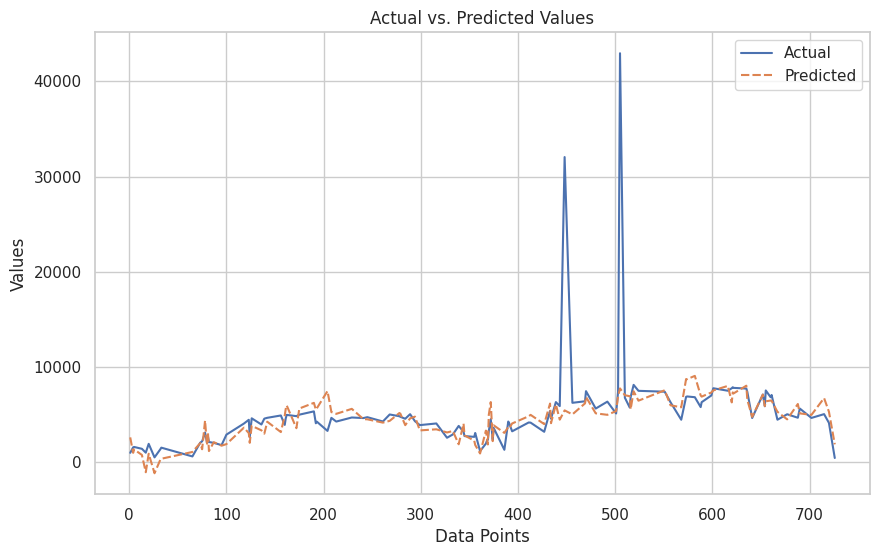

In [13]:
actual_vs_predicted(y_validate, y_pred)

# 2 Missing Values

### Helpers

In [14]:
class DatetimeConverter(BaseEstimator, TransformerMixin):
    def __init__(self, columns: list, date_format=None):
        """
        Initialize the transformer with target columns and optional datetime format.
        
        Args:
            columns (list): List of column names to convert to datetime.
            date_format (str, optional): The datetime format to use for conversion. Defaults to None.
        """
        self.columns = columns
        self.date_format = date_format
    
    def fit(self, X, y=None):
        """
        Fit method. This transformer does not need to learn anything from the data,
        so it just returns itself.
        
        Args:
            X (pd.DataFrame): The input DataFrame.
            y (None, optional): Ignored. Defaults to None.
        
        Returns:
            self: The fitted transformer.
        """
        return self
    
    def transform(self, X):
        """
        Apply the datetime conversion to the target columns.
        
        Args:
            X (pd.DataFrame): The input DataFrame to transform.
        
        Returns:
            pd.DataFrame: The DataFrame with the target columns converted to datetime.
        """
        # Ensure we don't modify the original DataFrame
        X = X.copy()
        
        # Convert each target column to datetime
        for column in self.columns:
            X[column] = pd.to_datetime(X[column], format=self.date_format)
        
        return X

In [15]:
class SeasonImputer(BaseEstimator, TransformerMixin):
    def __init__(self, target_column: str, date_column: str):
        """
        Initialize the transformer with the name of the target column for the season
        and the date column from which the season will be determined.
        
        Args:
            target_column (str): The name of the column to store the imputed season.
            date_column (str): The name of the date column to determine the season from.
        """
        self.target_column = target_column
        self.date_column = date_column
    
    def fit(self, X, y=None):
        """
        Fit method for the transformer. Since this transformer does not need to learn
        anything from the data, it just returns itself.
        
        Args:
            X (pd.DataFrame): The input DataFrame.
            y (None, optional): Not used, for compatibility with scikit-learn's transformer requirements.
        
        Returns:
            self: The fitted transformer.
        """
        return self  # No fitting necessary
    
    def transform(self, X):
        """
        Apply the season imputation to the DataFrame.
        
        Args:
            X (pd.DataFrame): The input DataFrame to transform.
        
        Returns:
            pd.DataFrame: The DataFrame with the season imputed.
        """
        # Ensure we don't modify the original DataFrame
        X = X.copy()
        
        # Define the function to determine the season based on the day of the year
        def get_season(date):
            day_of_year = date.timetuple().tm_yday
            if 80 <= day_of_year < 172:
                return 2  # Spring
            elif 172 <= day_of_year < 265:
                return 3  # Summer
            elif 265 <= day_of_year < 355:
                return 4  # Fall
            else:
                return 1  # Winter
        
        # Check if the date column exists and apply the season calculation
        if self.date_column in X.columns:
            X[self.target_column] = X[self.date_column].apply(lambda x: get_season(x) if pd.notnull(x) else x)
        
        return X

### Pipeline

In [16]:
datetime_converter = DatetimeConverter(columns=['dteday'], date_format='%d.%m.%Y')
season_imputer = SeasonImputer(target_column='season', date_column='dteday')

In [17]:
pipeline = make_pipeline(
    datetime_converter,
    season_imputer,
    minimal_preprocessing,
    LinearRegression()
)

### Evaluation

In [18]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('datetimeconverter',
                 DatetimeConverter(columns=['dteday'], date_format='%d.%m.%Y')),
                ('seasonimputer',
                 SeasonImputer(date_column='dteday', target_column='season')),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['dteday', 'casual',
                                                   'registered', 'cnt']),
                                                 ('simpleimputer',
                                                  SimpleImputer(),
                                                  ['season', 'hum'])])),
                ('linearregression', LinearRegression())])

In [19]:
y_pred = pipeline.predict(X_validate)

In [20]:
measures = performance_measures(y_validate, y_pred, len(pipeline.named_steps.linearregression.coef_))

R2: 0.22
Adjusted R2: 0.13
MAE: 1316.64
RMSE: 4149.23


In [21]:
data['Missing_Values'] = measures

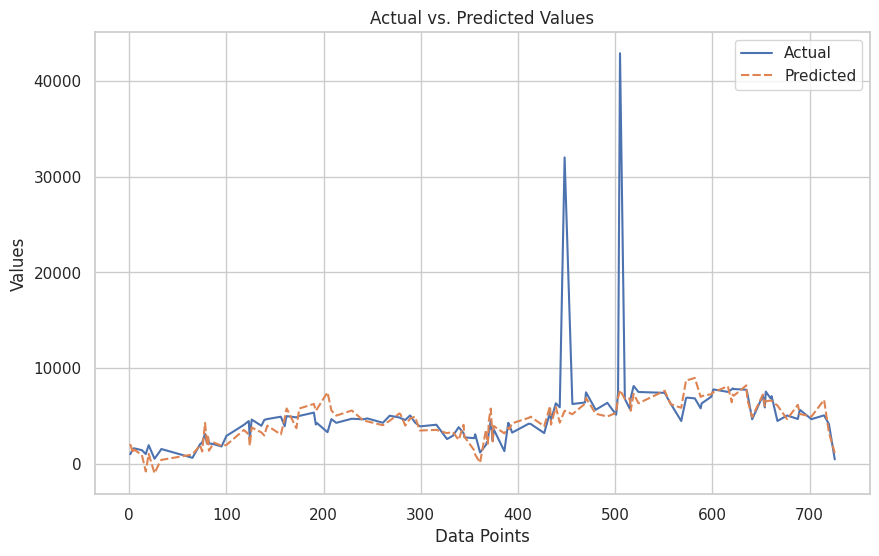

In [22]:
actual_vs_predicted(y_validate, y_pred)

# 3 Data Correction

### Helpers

In [23]:
class WeekdayMapper(BaseEstimator, TransformerMixin):
    def __init__(self, target_column: str, date_column: str):
        """
        Initialize the transformer with the name of the target column for the weekday
        and the date column from which the weekday will be determined.
        
        Args:
            target_column (str): The name of the column to store the mapped weekday.
            date_column (str): The name of the date column to determine the weekday from.
        """
        self.target_column = target_column
        self.date_column = date_column
    
    def fit(self, X, y=None):
        """
        Fit method for the transformer. Since this transformer does not need to learn
        anything from the data, it just returns itself.
        
        Args:
            X (pd.DataFrame): The input DataFrame.
            y (None, optional): Not used, for compatibility with scikit-learn's transformer requirements.
        
        Returns:
            self: The fitted transformer.
        """
        return self  # No fitting necessary
    
    def transform(self, X):
        """
        Apply the weekday mapping to the DataFrame based on the date column.
        
        Args:
            X (pd.DataFrame): The input DataFrame to transform.
        
        Returns:
            pd.DataFrame: The DataFrame with the weekday column mapped.
        """
        # Ensure we don't modify the original DataFrame
        X = X.copy()
        
        # Check if the date column exists and map the weekday
        if self.date_column in X.columns:
            # Maps the weekday based on the date column, where Monday=0, Sunday=6, then adjusts to Monday=1, Sunday=0
            X[self.target_column] = (X[self.date_column].dt.dayofweek + 1) % 7
        
        return X

In [24]:
class ThresholdImputer(BaseEstimator, TransformerMixin):
    def __init__(self, target_column: str, threshold: Union[int, float] = 0.0, impute_above: bool = False):
        """
        Initialize the transformer with the target column for imputation, the threshold value, and the direction of imputation.
        
        Args:
            target_column (str): The target column for imputation.
            threshold (Union[int, float]): The threshold value for imputation.
            impute_above (bool): If True, values above the threshold will be imputed; if False, values below the threshold will be imputed.
        """
        self.target_column = target_column
        self.threshold = threshold
        self.impute_above = impute_above
    
    def fit(self, X, y=None):
        """
        Fit method for the transformer. Calculates the mean of the target column values either above or below the threshold based on the direction of imputation.
        
        Args:
            X (pd.DataFrame): The input DataFrame.
            y (None, optional): Not used, for compatibility with scikit-learn's transformer requirements.
        
        Returns:
            self: The fitted transformer.
        """
        if self.target_column in X.columns:
            if self.impute_above:
                # Calculate mean of values below the threshold for imputing values above it
                self.mean_value_ = X.loc[X[self.target_column] <= self.threshold, self.target_column].mean()
            else:
                # Calculate mean of values above the threshold for imputing values below it
                self.mean_value_ = X.loc[X[self.target_column] >= self.threshold, self.target_column].mean()
        return self
    
    def transform(self, X):
        """
        Apply the imputation to the target column based on the threshold value and direction of imputation.
        
        Args:
            X (pd.DataFrame): The input DataFrame to transform.
        
        Returns:
            pd.DataFrame: The DataFrame with values in the target column imputed based on the specified criteria.
        """
        X = X.copy()  # Work on a copy of the DataFrame to avoid altering original data
        if self.target_column in X.columns:
            if self.impute_above:
                # Impute values above the threshold
                X.loc[X[self.target_column] > self.threshold, self.target_column] = self.mean_value_
            else:
                # Impute values below the threshold
                X.loc[X[self.target_column] < self.threshold, self.target_column] = self.mean_value_
        return X

In [25]:
class ThresholdRowRemover(BaseEstimator, TransformerMixin):
    def __init__(self, target_column: str, threshold: Union[int, float] = 0.0):
        """
        Initialize the transformer with the target column for row removal and the threshold value.
        
        Args:
            target (str): The target column for row removal.
            threshold (Union[int, float]): The threshold below which rows will be removed.
        """
        self.target_column = target_column
        self.threshold = threshold
    
    def fit(self, X, y=None):
        """
        Fit method for the transformer. This transformer does not need to learn anything from the data,
        so it just returns itself.
        
        Args:
            X (pd.DataFrame): The input DataFrame.
            y (None, optional): Not used, for compatibility with scikit-learn's transformer requirements.
        
        Returns:
            self: The fitted transformer.
        """
        return self  # No fitting necessary
    
    def transform(self, X):
        """
        Remove rows from the DataFrame where the target column's value is below the threshold.
        
        Args:
            X (pd.DataFrame): The input DataFrame to transform.
        
        Returns:
            pd.DataFrame: The DataFrame with rows removed where the target column's value is below the threshold.
        """
        X = X.copy()  # Work on a copy of the DataFrame to avoid altering original data
        if self.target_column in X.columns:
            X = X[X[self.target_column] >= self.threshold]
        return X

### Pipeline

In [26]:
correct_weekday = WeekdayMapper(target_column='weekday', date_column='dteday')

In [27]:
windspeed_mean_imputer = ThresholdImputer(target_column='windspeed', threshold=0.0)
windspeed_remover = ThresholdRowRemover(target_column='windspeed', threshold=0.0)

In [28]:
pipeline = make_pipeline(
    datetime_converter,
    season_imputer,
    correct_weekday,
    windspeed_mean_imputer,
    minimal_preprocessing,
    LinearRegression()
)

### Evaluation

In [29]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('datetimeconverter',
                 DatetimeConverter(columns=['dteday'], date_format='%d.%m.%Y')),
                ('seasonimputer',
                 SeasonImputer(date_column='dteday', target_column='season')),
                ('weekdaymapper',
                 WeekdayMapper(date_column='dteday', target_column='weekday')),
                ('thresholdimputer',
                 ThresholdImputer(target_column='windspeed')),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['dteday', 'casual',
                                                   'registered', 'cnt']),
                                                 ('simpleimputer',
                                                  SimpleImputer(),
                                                  ['season', 'hum'])])),
                ('linearregression', LinearRegression())])

In [30]:
y_pred = pipeline.predict(X_validate)

In [31]:
measures = performance_measures(y_validate, y_pred, len(pipeline.named_steps.linearregression.coef_))

R2: 0.22
Adjusted R2: 0.12
MAE: 1348.47
RMSE: 4160.33


In [32]:
data['Data_Correction'] = measures

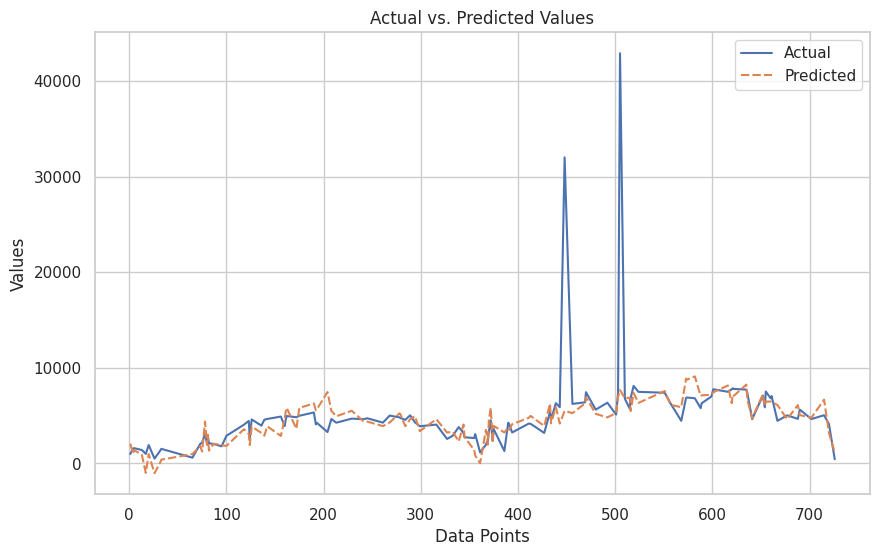

In [33]:
actual_vs_predicted(y_validate, y_pred)

# 4 Outlier Handling

### Helpers

In [34]:
class RegressionImputationOutlier(BaseEstimator, TransformerMixin):
    def __init__(self, target: str, feature_columns: list, threshold: float = 3.0):
        """
        Initialize the transformer with the target column for outlier imputation, the feature columns
        to use for predicting the target, and the Z-score threshold.
        
        Args:
            target (str): The target column for outlier imputation.
            feature_columns (list): The list of column names to be used as features for regression.
            threshold (float): Z-score threshold to consider a data point an outlier.
        """
        self.target = target
        self.feature_columns = feature_columns
        self.threshold = threshold
        self.model = LinearRegression()
    
    def fit(self, X, y=None):
        """
        Fit method for the transformer. Fits a linear regression model using non-outlier data points.
        
        Args:
            X (pd.DataFrame): The input DataFrame.
            y (None, optional): Not used, for compatibility with scikit-learn's transformer requirements.
        
        Returns:
            self: The fitted transformer.
        """
        X = X.copy()
        if self.target in X.columns and all(col in X.columns for col in self.feature_columns):
            # Calculate Z-scores for the target column
            z_scores = zscore(X[self.target].dropna())
            non_outliers = abs(z_scores) <= self.threshold
            
            # Fit the model using non-outlier data
            self.model.fit(X.loc[non_outliers, self.feature_columns], X.loc[non_outliers, self.target])
        return self
    
    def transform(self, X):
        """
        Impute outliers in the DataFrame based on predictions from the fitted linear regression model.
        
        Args:
            X (pd.DataFrame): The input DataFrame to transform.
        
        Returns:
            pd.DataFrame: The DataFrame with outliers in the specified target column imputed.
        """
        X = X.copy()
        if self.target in X.columns and all(col in X.columns for col in self.feature_columns):
            # Calculate Z-scores for the target column again
            z_scores = zscore(X[self.target].dropna())
            outliers = abs(z_scores) > self.threshold
            
            # Predict and impute values for outliers using the fitted model
            predicted_values = self.model.predict(X.loc[outliers, self.feature_columns])
            X.loc[X[self.target].dropna().index[outliers], self.target] = predicted_values.astype(int)
        return X

In [35]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, target: str, threshold: float = 3.0):
        """
        Initialize the transformer with the target column for outlier removal and the Z-score threshold.
        
        Args:
            target (str): The target column for outlier removal.
            threshold (float): Z-score threshold to consider a data point an outlier.
        """
        self.target = target
        self.threshold = threshold
    
    def fit(self, X, y=None):
        """
        Fit method for the transformer. This transformer does not need to learn anything from the data,
        so it just returns itself.
        
        Args:
            X (pd.DataFrame): The input DataFrame.
            y (None, optional): Not used, for compatibility with scikit-learn's transformer requirements.
        
        Returns:
            self: The fitted transformer.
        """
        return self
    
    def transform(self, X):
        """
        Remove outliers from the DataFrame based on the Z-score threshold in the target column.
        
        Args:
            X (pd.DataFrame): The input DataFrame to transform.
        
        Returns:
            pd.DataFrame: The DataFrame with outliers removed from the specified target column.
        """
        X = X.copy()  # Work on a copy of the DataFrame to avoid altering original data
        if self.target in X.columns:
            # Calculate Z-scores for the target column
            z_scores = zscore(X[self.target].dropna())
            # Identify outliers
            outliers = abs(z_scores) > self.threshold
            # Drop outliers
            X = X[~X[self.target].index.isin(X[self.target].dropna().index[outliers])]
            print(f"{X.shape[0]} rows remaining after removing outliers.")
        return X

### Pipeline

In [36]:
outlier_remover = OutlierRemover(target='cnt', threshold=3.0)

In [37]:
X_train = outlier_remover.transform(X_train)

478 rows remaining after removing outliers.


In [38]:
y_train = outlier_remover.transform(y_train.to_frame()).squeeze()

478 rows remaining after removing outliers.


In [39]:
pipeline = make_pipeline(
    datetime_converter,
    season_imputer,
    correct_weekday,
    windspeed_mean_imputer,
    minimal_preprocessing,
    LinearRegression()
)

### Evaluation

In [40]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('datetimeconverter',
                 DatetimeConverter(columns=['dteday'], date_format='%d.%m.%Y')),
                ('seasonimputer',
                 SeasonImputer(date_column='dteday', target_column='season')),
                ('weekdaymapper',
                 WeekdayMapper(date_column='dteday', target_column='weekday')),
                ('thresholdimputer',
                 ThresholdImputer(target_column='windspeed')),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['dteday', 'casual',
                                                   'registered', 'cnt']),
                                                 ('simpleimputer',
                                                  SimpleImputer(),
                                                  ['season', 'hum'])])),
                ('linearregression', LinearRegression())])

In [41]:
y_pred = pipeline.predict(X_validate)

In [42]:
measures = performance_measures(y_validate, y_pred, len(pipeline.named_steps.linearregression.coef_))

R2: 0.22
Adjusted R2: 0.12
MAE: 1158.06
RMSE: 4157.70


In [43]:
data['Outlier_Handling'] = measures

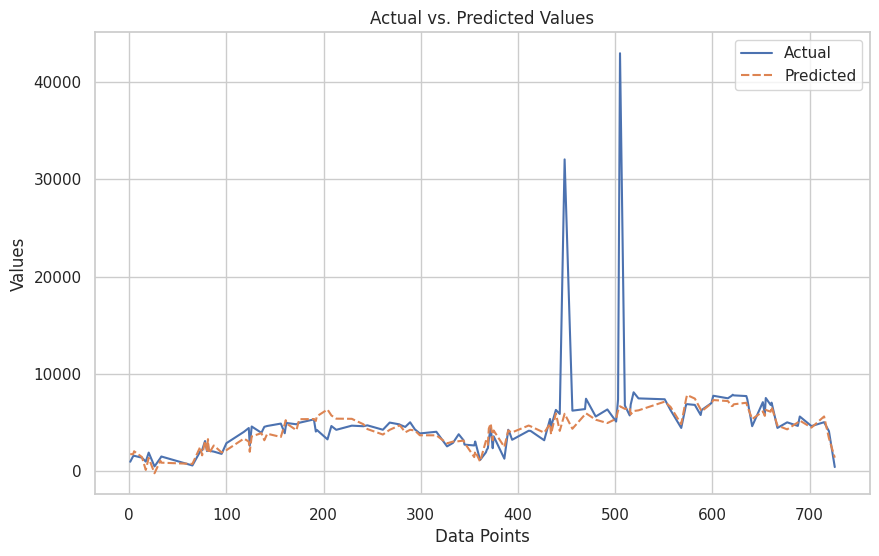

In [44]:
actual_vs_predicted(y_validate, y_pred)

# 5 Feature Transformation

## 5.1 One Hot Encoding

### Helpers

In [45]:
class GroupOneHotEncodedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, grouping_info):
        """
        Initialize the transformer with the grouping information for one-hot encoded columns.
        
        Parameters:
        - grouping_info: Dictionary where keys are the new column names for the groups
                         and values are lists of columns to be grouped.
        """
        self.grouping_info = grouping_info
    
    def fit(self, X, y=None):
        """
        Fit method for the transformer. This transformer does not need to learn anything from the data,
        so it just returns itself.
        
        Parameters:
        - X: pandas DataFrame containing one-hot encoded columns.
        - y: Not used, for compatibility with scikit-learn's transformer requirements.
        
        Returns:
        - self: The fitted transformer.
        """
        return self  # No fitting necessary
    
    def transform(self, X):
        """
        Apply the grouping to the one-hot encoded columns based on the provided grouping information.
        
        Parameters:
        - X: pandas DataFrame to transform.
        
        Returns:
        - DataFrame with grouped columns.
        """
        # Ensure we don't modify the original DataFrame
        X_transformed = X.copy()
        
        for new_col, columns_to_group in self.grouping_info.items():
            # Create a new column for the group, using `max` as an example aggregation
            X_transformed[new_col] = X_transformed[columns_to_group].max(axis=1)
            
            # Drop the original columns that were grouped
            X_transformed.drop(columns=columns_to_group, inplace=True)
        
        return X_transformed

### Pipeline

In [46]:
weekend_group = GroupOneHotEncodedTransformer(grouping_info={'weekend': ['onehotencoder__weekday_0', 'onehotencoder__weekday_6']})
weekday_group = GroupOneHotEncodedTransformer(grouping_info={'weekday': ['onehotencoder__weekday_1', 'onehotencoder__weekday_2', 'onehotencoder__weekday_3', 'onehotencoder__weekday_4', 'onehotencoder__weekday_5']})

In [47]:
feature_transformer = make_column_transformer(
    (OneHotEncoder(sparse_output=False, dtype=int), ['season', 'weekday', 'weathersit']),
    (SimpleImputer(strategy='mean'), ['hum']),
    ('drop', ['workingday', 'mnth', 'dteday', 'cnt', 'casual', 'registered']),
    remainder='passthrough'
)

In [48]:
pipeline = make_pipeline(
    datetime_converter,
    season_imputer,
    correct_weekday,
    windspeed_mean_imputer,
    feature_transformer,
    weekend_group,
    weekday_group,
    LinearRegression()
)

### Evaluation

In [49]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('datetimeconverter',
                 DatetimeConverter(columns=['dteday'], date_format='%d.%m.%Y')),
                ('seasonimputer',
                 SeasonImputer(date_column='dteday', target_column='season')),
                ('weekdaymapper',
                 WeekdayMapper(date_column='dteday', target_column='weekday')),
                ('thresholdimputer',
                 ThresholdImputer(target_column='windspeed')),
                ('columntransformer',
                 ColumnTran...
                 GroupOneHotEncodedTransformer(grouping_info={'weekend': ['onehotencoder__weekday_0',
                                                                          'onehotencoder__weekday_6']})),
                ('grouponehotencodedtransformer-2',
                 GroupOneHotEncodedTransformer(grouping_info={'weekday': ['onehotencoder__weekday_1',
                                                                          'onehotencoder__weekday_2',
                                                                          'onehotencoder__weekday_3',
                                                                          'onehotencoder__weekday_4',
                                                                          'onehotencoder__weekday_5']})),
                ('linearregression', LinearRegression())])

In [50]:
y_pred = pipeline.predict(X_validate)

In [51]:
measures = performance_measures(y_validate, y_pred, len(pipeline.named_steps.linearregression.coef_))

R2: 0.24
Adjusted R2: 0.11
MAE: 1103.02
RMSE: 4113.93


In [52]:
data['One_Hot_Encoder'] = measures

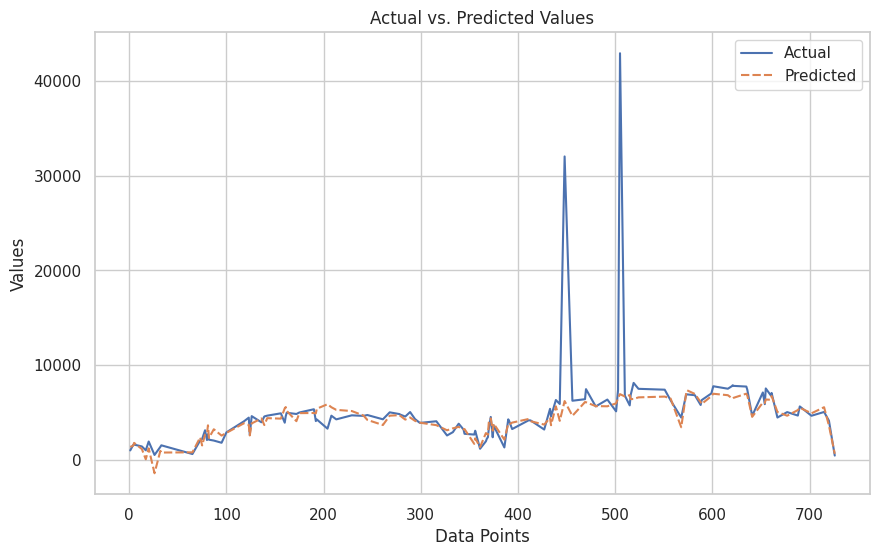

In [53]:
actual_vs_predicted(y_validate, y_pred)

## 5.2 Normalisierung

### Pipeline

In [54]:
scale_features = make_column_transformer(
    (StandardScaler(), [
        'remainder__temp',
        'remainder__atemp',
        'remainder__windspeed',
        'remainder__leaflets',
        'simpleimputer__hum'
        ]
    ),
    remainder='passthrough'
)

In [55]:
pipeline = make_pipeline(
    datetime_converter,
    season_imputer,
    correct_weekday,
    windspeed_mean_imputer,
    feature_transformer,
    weekend_group,
    weekday_group,
    scale_features,
    LinearRegression()
)

### Evaluation

In [56]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('datetimeconverter',
                 DatetimeConverter(columns=['dteday'], date_format='%d.%m.%Y')),
                ('seasonimputer',
                 SeasonImputer(date_column='dteday', target_column='season')),
                ('weekdaymapper',
                 WeekdayMapper(date_column='dteday', target_column='weekday')),
                ('thresholdimputer',
                 ThresholdImputer(target_column='windspeed')),
                ('columntransformer-1',
                 ColumnTr...
                                                                          'onehotencoder__weekday_2',
                                                                          'onehotencoder__weekday_3',
                                                                          'onehotencoder__weekday_4',
                                                                          'onehotencoder__weekday_5']})),
                ('columntransformer-2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['remainder__temp',
                                                   'remainder__atemp',
                                                   'remainder__windspeed',
                                                   'remainder__leaflets',
                                                   'simpleimputer__hum'])])),
                ('linearregression', LinearRegression())])

In [57]:
y_pred = pipeline.predict(X_validate)

In [58]:
measures = performance_measures(y_validate, y_pred, len(pipeline.named_steps.linearregression.coef_))

R2: 0.24
Adjusted R2: 0.11
MAE: 1103.02
RMSE: 4113.93


In [59]:
data['Normalization'] = measures

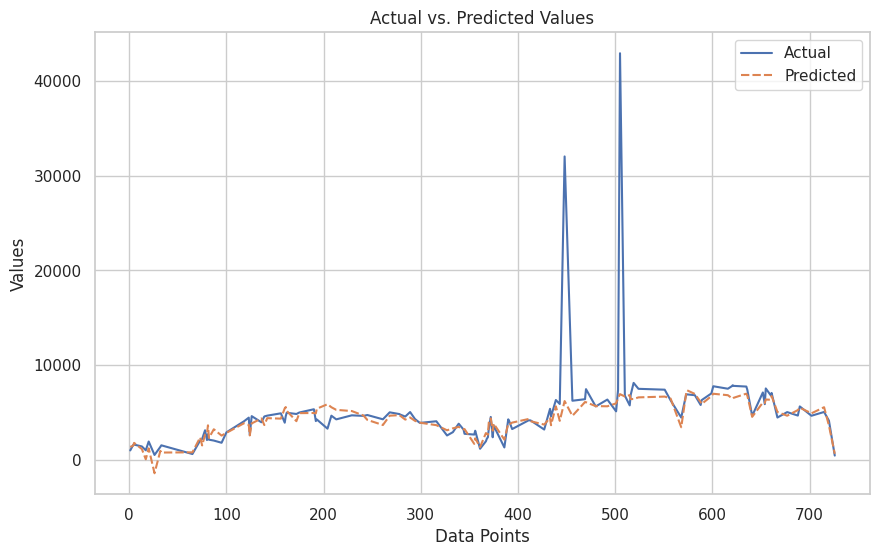

In [60]:
actual_vs_predicted(y_validate, y_pred)

# 6 Multikolinearität

### Pipeline

In [61]:
multicollinearity = make_column_transformer(
    ('drop', ['standardscaler__remainder__temp']),
    remainder='passthrough'
)

In [62]:
pipeline = make_pipeline(
    datetime_converter,
    season_imputer,
    correct_weekday,
    windspeed_mean_imputer,
    feature_transformer,
    weekend_group,
    weekday_group,
    scale_features,
    multicollinearity,
    LinearRegression()
)

### Evaluation

In [63]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('datetimeconverter',
                 DatetimeConverter(columns=['dteday'], date_format='%d.%m.%Y')),
                ('seasonimputer',
                 SeasonImputer(date_column='dteday', target_column='season')),
                ('weekdaymapper',
                 WeekdayMapper(date_column='dteday', target_column='weekday')),
                ('thresholdimputer',
                 ThresholdImputer(target_column='windspeed')),
                ('columntransformer-1',
                 ColumnTr...
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['remainder__temp',
                                                   'remainder__atemp',
                                                   'remainder__windspeed',
                                                   'remainder__leaflets',
                                                   'simpleimputer__hum'])])),
                ('columntransformer-3',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['standardscaler__remainder__temp'])])),
                ('linearregression', LinearRegression())])

In [64]:
final_model = pipeline.named_steps.linearregression

In [65]:
y_pred = pipeline.predict(X_validate)

In [66]:
measures = performance_measures(y_validate, y_pred, len(pipeline.named_steps.linearregression.coef_))

R2: 0.23
Adjusted R2: 0.12
MAE: 1108.29
RMSE: 4120.99


In [67]:
data['Multicolinearity'] = measures

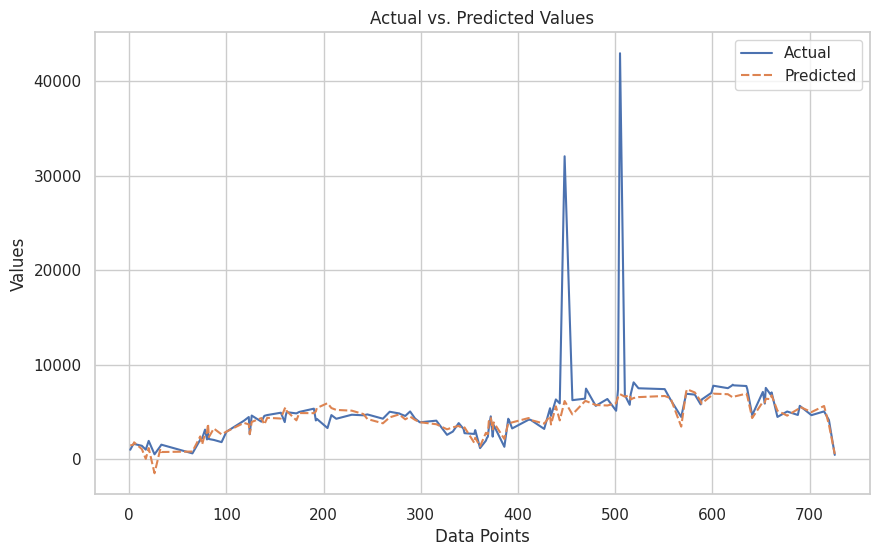

In [68]:
actual_vs_predicted(y_validate, y_pred)

# Validation

### With Outliers

In [69]:
y_pred = pipeline.predict(test_data)

In [70]:
measures = performance_measures(test_data['cnt'], y_pred, len(pipeline.named_steps.linearregression.coef_))

R2: 0.40
Adjusted R2: 0.31
MAE: 839.54
RMSE: 2415.38


In [71]:
data['Test_Validation'] = measures

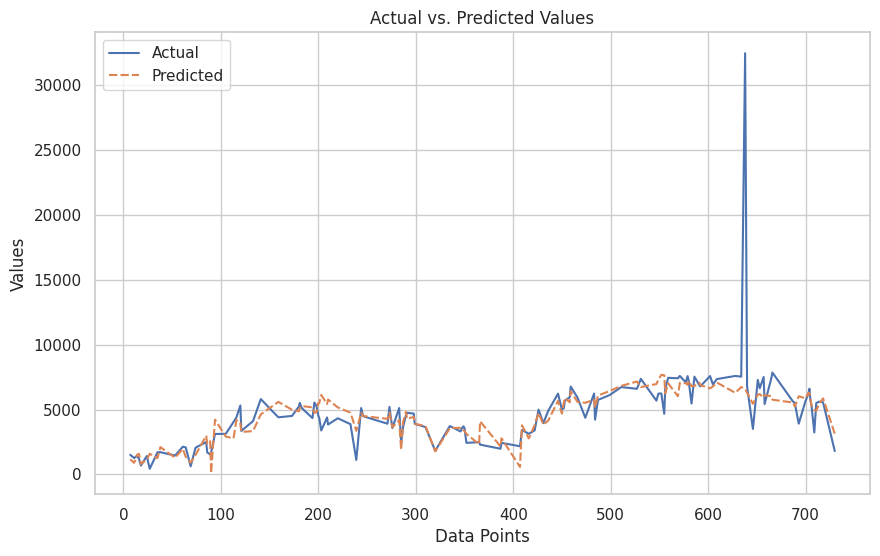

In [72]:
actual_vs_predicted(test_data['cnt'], y_pred)

### Without Outliers

In [73]:
test_data_without_outliers = outlier_remover.transform(test_data)

131 rows remaining after removing outliers.


In [74]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('datetimeconverter',
                 DatetimeConverter(columns=['dteday'], date_format='%d.%m.%Y')),
                ('seasonimputer',
                 SeasonImputer(date_column='dteday', target_column='season')),
                ('weekdaymapper',
                 WeekdayMapper(date_column='dteday', target_column='weekday')),
                ('thresholdimputer',
                 ThresholdImputer(target_column='windspeed')),
                ('columntransformer-1',
                 ColumnTr...
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['remainder__temp',
                                                   'remainder__atemp',
                                                   'remainder__windspeed',
                                                   'remainder__leaflets',
                                                   'simpleimputer__hum'])])),
                ('columntransformer-3',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['standardscaler__remainder__temp'])])),
                ('linearregression', LinearRegression())])

In [75]:
y_pred = pipeline.predict(test_data_without_outliers)

In [76]:
measures = performance_measures(test_data_without_outliers['cnt'], y_pred, len(pipeline.named_steps.linearregression.coef_))

R2: 0.80
Adjusted R2: 0.77
MAE: 648.42
RMSE: 875.88


In [77]:
data['Test_Validation_Without_Outliers'] = measures

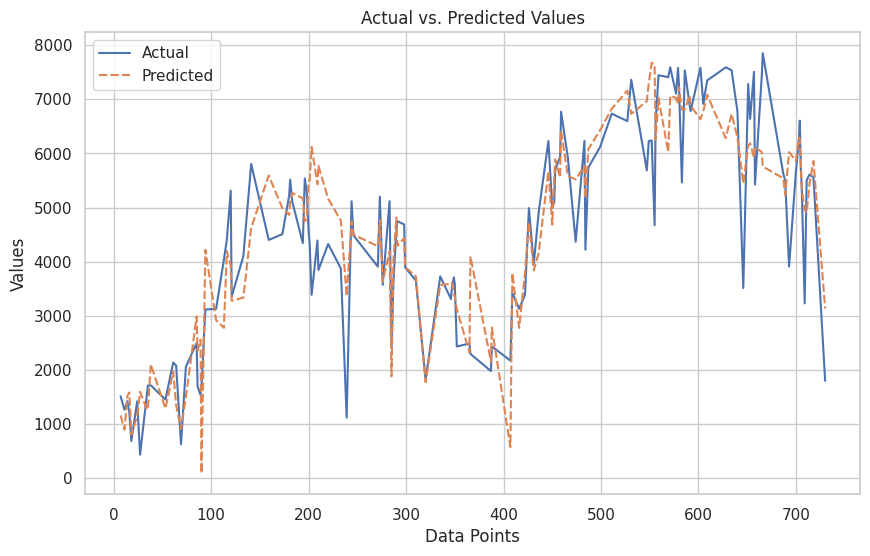

In [78]:
actual_vs_predicted(test_data_without_outliers['cnt'], y_pred)

# Performance Vergleich

Abschließend ist aus den folgenden Diagrammen ersichtlich, wie sich die Performance Measures im Laufe des Data Preparation Prozesses verbessert haben. 

Während die Werte für RMSE und MAE reduziert wurden, haben die Werte für R-Squared sowie Adjusted R-Squared stetig zugenommen.

In [79]:
performance_vergleich = pd.DataFrame(data)

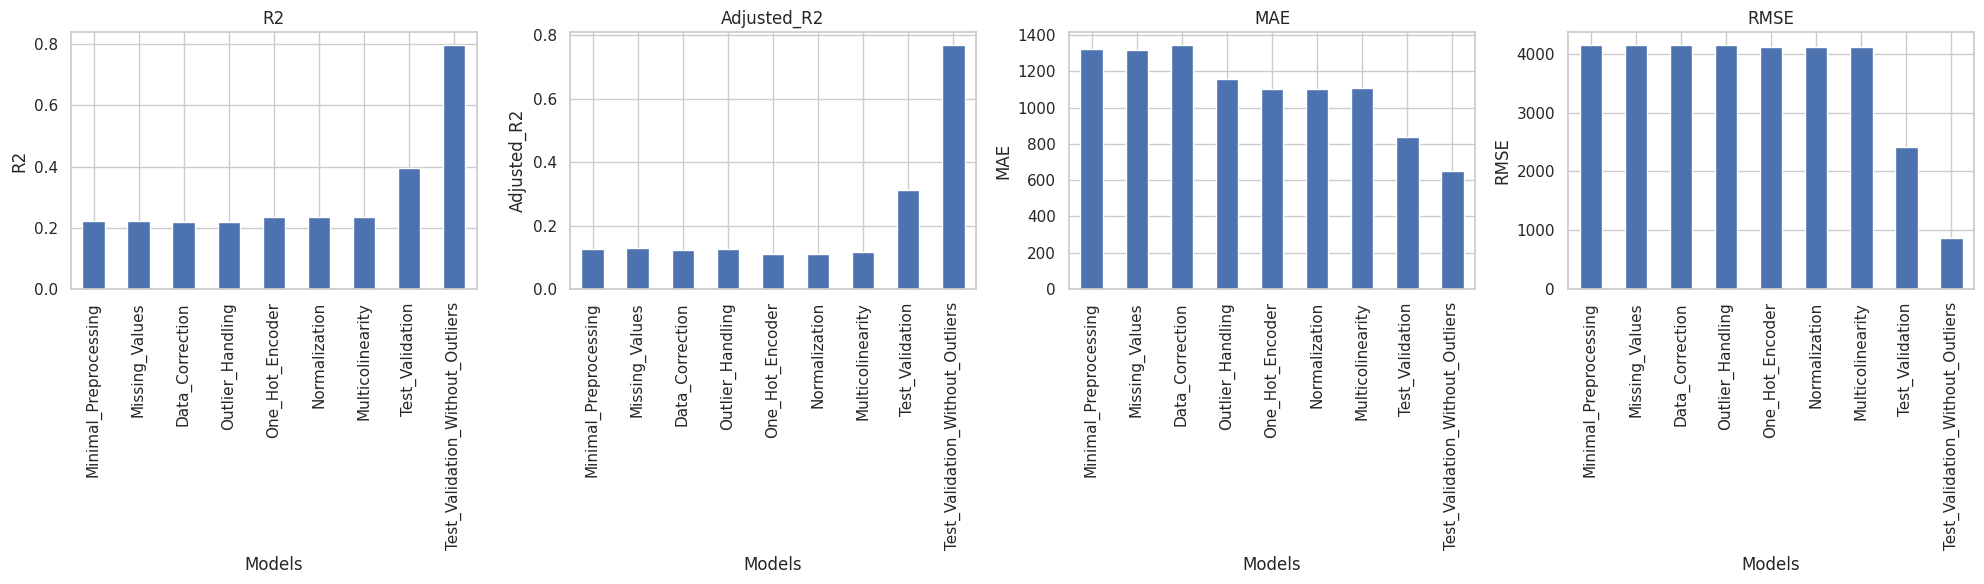

In [80]:
plot_comparative_bar_charts(performance_vergleich.T, metrics)

# Exportieren der Daten

### Helpers

In [81]:
def clean_column_names(df):
    """
    Cleans DataFrame column names by removing 'remainder__' prefixes.

    Args:
        df (pandas.DataFrame): The DataFrame with column names to clean.

    Returns:
        pandas.DataFrame: A DataFrame with cleaned column names.
    """
    # Use a dictionary comprehension to create a mapping of old to new names
    rename_map = {col: '__'.join(col.split('__')[-1:]) for col in df.columns}
    
    # Rename the columns using the mapping
    df_renamed = df.rename(columns=rename_map)
    
    return df_renamed

### Pipeline

In [82]:
column_name_transformer = FunctionTransformer(clean_column_names)

In [83]:
test_data = outlier_remover.transform(test_data)
X_validate = outlier_remover.transform(X_validate)
y_validate = outlier_remover.transform(y_validate.to_frame()).squeeze()

131 rows remaining after removing outliers.
118 rows remaining after removing outliers.
118 rows remaining after removing outliers.


In [84]:
data_processing_pipeline = make_pipeline(
    datetime_converter,
    season_imputer,
    correct_weekday,
    windspeed_mean_imputer,
    feature_transformer,
    weekend_group,
    weekday_group,
    scale_features,
    multicollinearity,
    column_name_transformer
)

In [85]:
processed_test_data = data_processing_pipeline.fit_transform(test_data)
X_train = data_processing_pipeline.fit_transform(X_train)
X_validate = data_processing_pipeline.fit_transform(X_validate)

### Export

In [86]:
model_filename = '../models/final_model_task2.pkl'
pickle.dump(final_model, open(model_filename, 'wb'))

train_data_filename = '../data/train_data_task2.csv'
processed_train_data = pd.concat([X_train, y_train], axis=1)
processed_train_data.to_csv(train_data_filename, index=False)

validation_data_filename = '../data/validation_data_task2.csv'
processed_validate_data = pd.concat([X_validate, y_validate], axis=1)
processed_validate_data.to_csv(validation_data_filename, index=False)

test_data_filename = '../data/test_data_task2.csv'
test_data = pd.concat([processed_test_data, test_data['cnt']], axis=1)
test_data.to_csv(test_data_filename, index=False)

print("All files saved successfully!")

All files saved successfully!


In [87]:
m = LinearRegression()

In [88]:
m.fit(X_train, y_train)

LinearRegression()

In [89]:
y_pred = m.predict(processed_test_data)

In [90]:
measures = performance_measures(test_data['cnt'], y_pred, len(m.coef_))

R2: 0.80
Adjusted R2: 0.78
MAE: 651.76
RMSE: 865.73


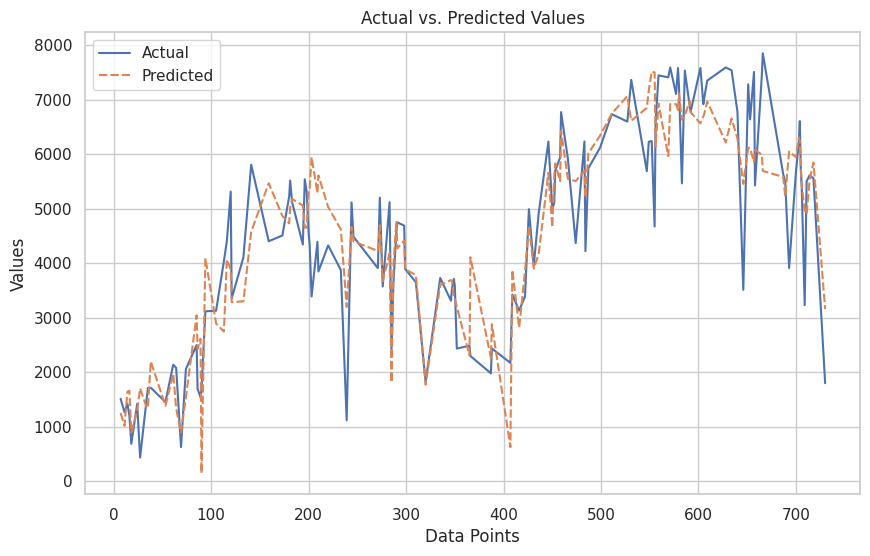

In [91]:
actual_vs_predicted(test_data['cnt'], y_pred)